# Enhancer proximity for DEGs in 24h dNipBL

***Purpose:*** Investigating whether enhancer proximity, as measured by distance between gene to closest enhancer or concentration of enhancers within the same TAD, are predictive of gene dysregulation in 1 day of dNipBL-depleted mESCs. 

**Process:** Plotting across the following variables:
* Portion of dysregulated genes sorted by distance to closest enhancer
* Number of enhancers within the same TAD compared to number of dysregulated genes in the same TAD

In [1]:
import plotting_histogram_functions as pfn
import filter_gene_functions as flt

In [2]:
# ignore FutureWarnings generated by pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import bioframe as bf
from gtfparse import read_gtf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

## Load data and project files

In [4]:
proj = "/project/fudenber_735/collaborations/karissa_2022/20220812_EA18-1_RNAseq-Analysis_forGeoff/"
# Importing day 1 depletion in ESCs DEGS
day1_sigRes = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_resSig_ESC_1d-depletion.csv'

normalized_counts = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_ESC-1d_sf-normalized.csv'
feature_counts = '20220816_featureCounts.csv'
WT_samples = ['KHRNA1', 'KHRNA7', 'KHRNA13', 'KHRNA22', 'KHRNA23', 'KHRNA50']

# import results table
day1_res_df = pd.read_csv(proj+day1_sigRes)

# add feature counts information to label genes not in the significant results table
feat_counts_df = pd.read_csv(proj+feature_counts)
day1_res_df = day1_res_df.merge(feat_counts_df['Geneid'], how='outer')

### Add feature annotations to gene set: TSS locations, DE status label, distance to closest enhancer

In [5]:
# Getting TSSEs
tss_df = read_gtf("/project/fudenber_735/collaborations/karissa_2022/old/RNAseq/STAR_Gencode_alignment/tss_annotions_gencode.vM23.primary_assembly.gtf")
ts_intervals = flt.get_tss_gene_intervals(tss_df)

# labelling our dataset
day1_res_df = day1_res_df.merge(ts_intervals, left_on='Geneid', right_on='gene_id', how='left')

# Checking if any of the significant genes will be lost due to loss of TSS annotation
print("Checking for 'lost' significant genes: ")
ix = np.where(day1_res_df['start'].isna() & (day1_res_df['padj'] < 0.05))
print("lost: ", str(day1_res_df.iloc[ix].shape[0]))
# If could not find a TSS, drop entire row
day1_res_df.dropna(subset=['start'], inplace=True)

# Remove any genes mapped to chrX before proceeding --> save these for later analysis
day1_res_df = day1_res_df[~day1_res_df.chrom.isin(['chrX'])]
day1_res_df = bf.sanitize_bedframe(day1_res_df)

# Add the differential expression status for filtering genes
day1_res_df = flt.label_DE_status(day1_res_df)

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'level', 'transcript_support_level', 'mgi_id', 'tag', 'havana_gene', 'havana_transcript', 'protein_id', 'ccdsid', 'ont']


Checking for 'lost' significant genes: 
lost:  0


### import enhancer files

In [6]:
dataset_folder = '/project/fudenber_735/collaborations/karissa_2022/2022_09_features_for_RNAseq/Published_datasets/'

chen_s1 = 'Enhancers_Chen2012_S1_remapped_mm10.bed'
whythe_super = 'Super-enhancers_mESCs_(OSN-MED1)_Wythe-Cell-2023_mm10-lifetover.bed'
# whythe_reg = 'remapped_enhancers_Whyte_2013_mm9.bed.txt' <-- where is this?

enhancers = {'chen_s1' : dataset_folder+chen_s1,
             'wythe_super' : dataset_folder+whythe_super}

### label distance to closest enhancer for each gene

In [8]:
for label, file in enhancers.items():
    day1_res_df = flt.label_closest_enhancer(day1_res_df, file, label)

In [9]:
print('how many genes did not receive an enhancer label --> dropped')
print((day1_res_df['chen_s1_distance'].isna() |
       day1_res_df['wythe_super_distance'].isna()
      ).sum())
day1_res_df.dropna(subset=
                   ['chen_s1_distance', 
                    'wythe_super_distance'], 
                   inplace=True
                  )

how many genes did not receive an enhancer label --> dropped
55


# Plot cumulative distance

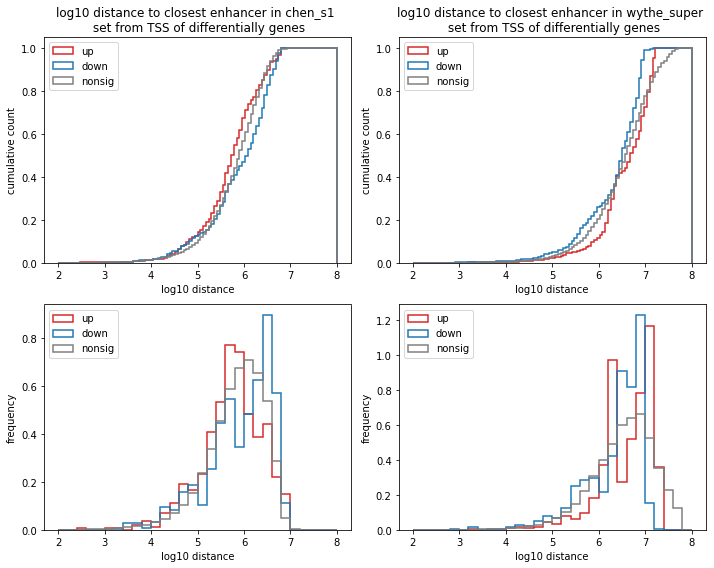

In [15]:
fig, axs = plt.subplots(2,2, figsize=(10, 8))

for (enhancer_label, file), axi in zip(enhancers.items(), np.arange(axs.shape[0])):
    pfn.plot_distance_histogram(day1_res_df, 
                                 enhancer_label+'_distance', 
                                 ax=axs[0, axi],
                                 cumulative=True,
                                 bins=100,
                                 plot_title='log10 distance to closest enhancer in {} \n set from TSS of differentially genes'.format(enhancer_label))
    
    pfn.plot_distance_histogram(day1_res_df, 
                                enhancer_label+'_distance', 
                                ax=axs[1, axi],
                                bins=30)
    
plt.tight_layout()
plt.show()

# Enhancer concentration compared to gene distribution within TAD Boundaries

* Investigating gene dysregulation relative to enhancers + HiC
* To answer question: How many dysregulated genes contain a distal enhancer in the same TAD?

### Load Hi-C data

Process insulation boundaries to represent TADs as genomic intervals

In [34]:
import importlib
importlib.reload(flt)

<module 'filter_gene_functions' from '/home1/pokorny/transcription_3Dfolding/transcription_3dfolding/transcription_data_analysis/filter_gene_functions.py'>

In [35]:
# load features for boundaries
feature_dir = '/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/features'
insulation_table = pd.read_table(feature_dir+'/bonev2017.HiC_ES.mm10.mapq_30.1000.window_200000.insulation')

tad_df = flt.tad_windows_from_boundaries(insulation_table)

### What are TAD window sizes

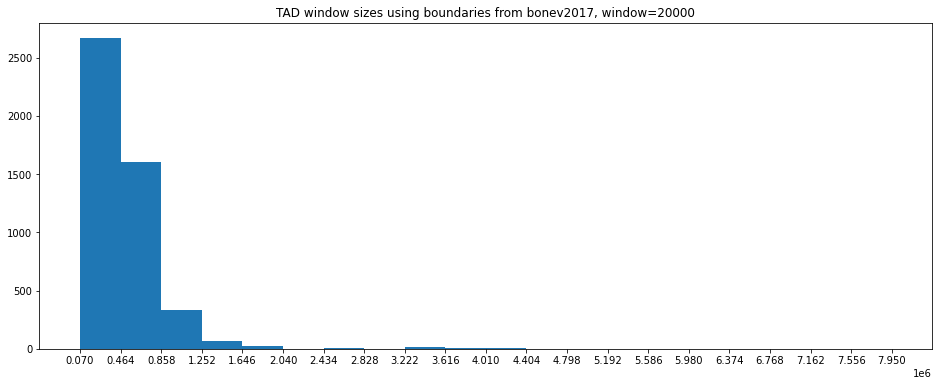

In [97]:
tad_sizes = tad_df['end'] - tad_df['start']
fig = plt.figure(figsize=(16,6))
n, bins, bars = plt.hist(tad_sizes.values, bins=20)

plt.xticks(bins.astype(np.double))
plt.title('TAD window sizes using boundaries from bonev2017, window=20000')
plt.show()

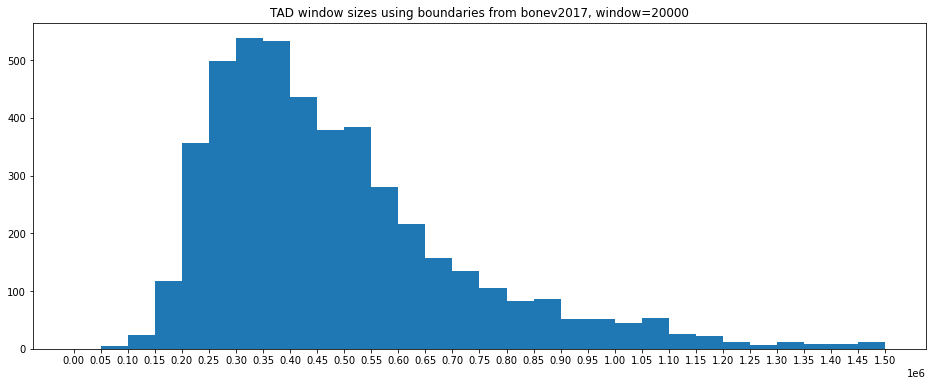

In [98]:
tad_sizes = tad_df['end'] - tad_df['start']
fig = plt.figure(figsize=(16,6))
n, bins, bars = plt.hist(tad_sizes.values, range=(0, 1.5e6), bins=30)

plt.xticks(bins.astype(np.double))
plt.title('TAD window sizes using boundaries from bonev2017, window=20000')
plt.show()

# Plot number of enhancers and distribution of genes within each TAD

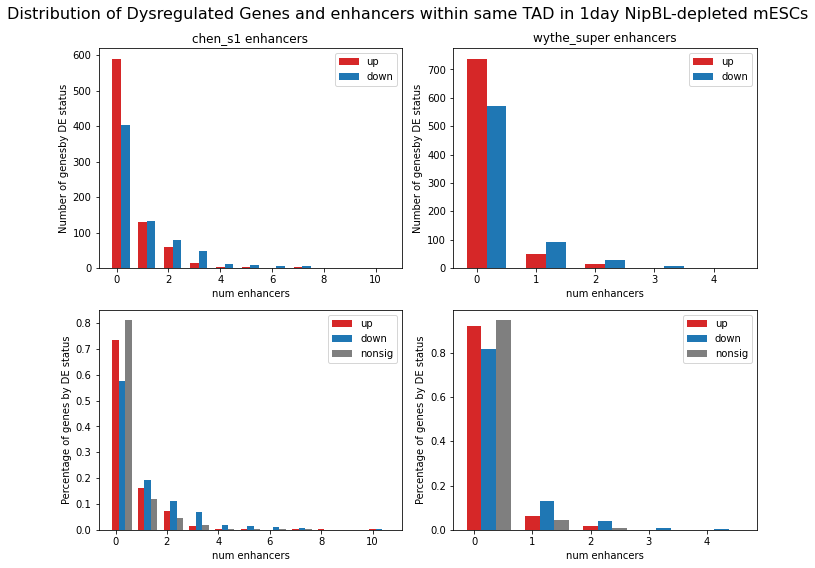

In [41]:
fig, axs = plt.subplots(2,2, figsize=(10, 8))
fig.suptitle(('Distribution of Dysregulated Genes and '
             'enhancers within same TAD in 1day NipBL-depleted mESCs'),
             fontsize=16)

for (enh_source, file), axi in zip(enhancers.items(), np.arange(axs.shape[0])):

    # Annotate number of enhancers within the tad
    df = tad_df.copy()
    enhancer_df = flt.get_enhancer_bioframe(file)
    tad_df['num_enhancers'] = bf.count_overlaps(tad_df, enhancer_df)['count']
    
    pfn.group_features_by_region(tad_df,
                                 day1_res_df,
                                 feature_category_colors={"up": 'tab:red', 
                                                      "down": 'tab:blue'},
                                 plot_title='{} enhancers'.format(enh_source),
                                 ax=axs[0, axi]
                                )
                                  
    pfn.distribution_features_by_region(tad_df,
                                        day1_res_df,
                                        plot_title='',
                                        ax=axs[1, axi]
                                       )
    
plt.tight_layout()
plt.show()

### Repeating above, using midpoint between insulation boundaries to define TAD windows

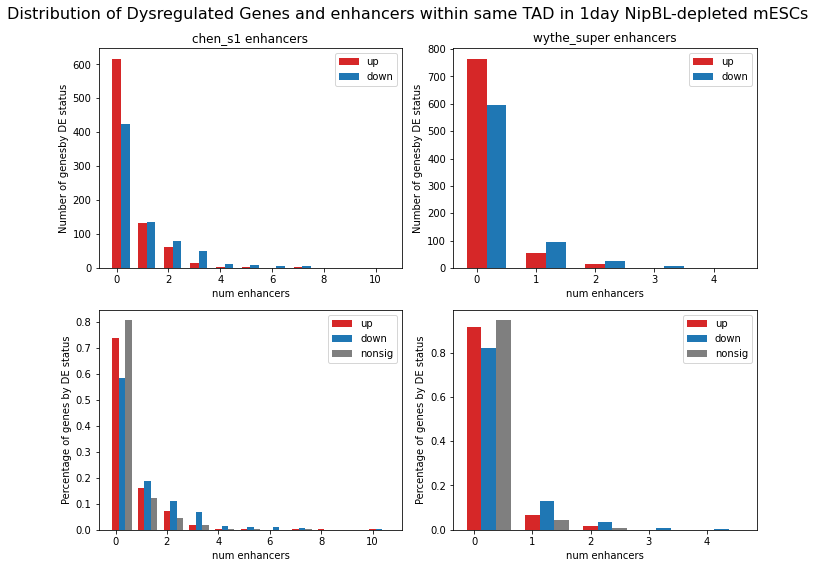

In [129]:
# Defining TADs using midpoints between boundaries
tad_mid_df = flt.tad_windows_from_boundaries(insulation_table, take_midpoint=True)

fig, axs = plt.subplots(2,2, figsize=(10, 8))
fig.suptitle(('Distribution of Dysregulated Genes and '
             'enhancers within same TAD in 1day NipBL-depleted mESCs'),
             fontsize=16)

for (enh_source, file), axi in zip(enhancers.items(), np.arange(axs.shape[0])):

    # Annotate number of enhancers within the tad
    df = tad_mid_df.copy()
    
    enhancer_df = flt.get_enhancer_bioframe(file)
    df['num_enhancers'] = bf.count_overlaps(df, enhancer_df)['count']
    
    pfn.group_features_by_region(df,
                                 day1_res_df,
                                 feature_category_colors={"up": 'tab:red', 
                                                      "down": 'tab:blue'},
                                 plot_title='{} enhancers'.format(enh_source),
                                 ax=axs[0, axi]
                                )
                                  
    pfn.distribution_features_by_region(df,
                                        day1_res_df,
                                        plot_title='',
                                        ax=axs[1, axi]
                                       )
    
plt.tight_layout()
plt.show()

## Other Explorations:

### Histogram to measure distribution of types of genes within each TAD?
   * Note: Not super informative --> there are less total DE genes, so it makes sense that they exist in lower numbers within TADs

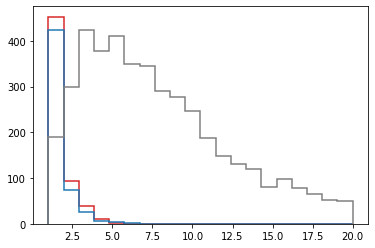

In [42]:
# This is plotting number of genes within each TAD window --> not yet categorized / labeled by number of enhancers within each TAD window
ax = plt.subplot()
agg_key='DE_status'
category_colors={"up": 'tab:red', 
                 "down": 'tab:blue', 
                 "nonsig": 'tab:gray'}
val_range=(1,20)
bins=20

df = day1_res_df.copy()
for cat, col in category_colors.items():

    cat_ix = np.where(df[agg_key] == cat)

    counts = bf.count_overlaps(tad_df, df.iloc[cat_ix])['count']

    ax.hist(counts,
            bins=bins,
            range=val_range,
            density=False,
            histtype='step',
            lw=1.5,
            label=cat, 
            color=col)


### How many up/down/non-reg genes fell in-between TADs?

Interpret as: how many TSSes are **within** the insulation boundaries, instead of between --> do these get skipped?

In [110]:
# Using the tad windows to re-create the insulation_boundary windows by performing inverse operation
chrom_sizes = flt.extract_chrom_sizes_from_insulation(insulation_table)
insulation_windows = flt.windows_from_boundaries(tad_df, chrom_sizes)

In [111]:
insulation_windows[0:5]

,chrom,start,end
0,chr1,0,0
1,chr1,3670000,3680000
2,chr1,4400000,4410000
3,chr1,4770000,4780000
4,chr1,5150000,5160000


up genes: 34 total have their promoter within an insulation window.
down genes: 29 total have their promoter within an insulation window.
nonsig genes: 1741 total have their promoter within an insulation window.


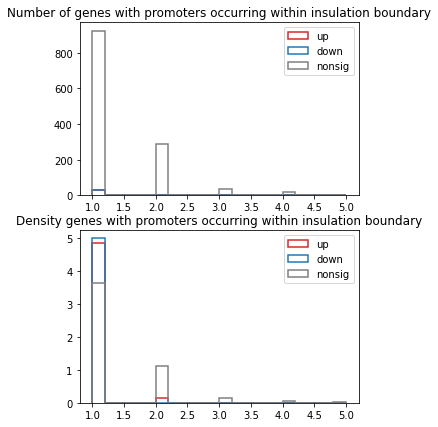

In [126]:
fig, (ax1, ax2)= plt.subplots(2, 1, figsize=(5, 7))
agg_key='DE_status'
category_colors={"up": 'tab:red', 
                 "down": 'tab:blue', 
                 "nonsig": 'tab:gray'}
val_range=(1,5)
bins=20

df = day1_res_df.copy()
for cat, col in category_colors.items():

    cat_ix = np.where(df[agg_key] == cat)

    counts = bf.count_overlaps(insulation_windows, df.iloc[cat_ix])['count']
    print('{} genes: {} total have their promoter within an insulation window.'.
          format(cat, counts.sum()))

    ax1.hist(counts,
            bins=bins,
            range=val_range,
            density=False,
            histtype='step',
            lw=1.5,
            label=cat, 
            color=col)
    ax1.set_title('Number of genes with promoters occurring within insulation boundary')
    ax1.legend()
    
    ax2.hist(counts,
            bins=bins,
            range=val_range,
            density=True,
            histtype='step',
            lw=1.5,
            label=cat, 
            color=col)
    ax2.set_title('Density genes with promoters occurring within insulation boundary')
    ax2.legend()

### Conclusions: We do have some genes with TSSes occuring along the insulation boundary

- There are some small number of down-regulat
- generating windows by mid-point may generate ~slightly different results